# Artificial Neural Networks and Deep Learning - first challange
This report has been created as the homework of the **Artificial Neural Networks and Deep Learning** course. Here, you can find step by step explanation of how to solve the problem. To ensure the process is repeatable, make sure to set the same seed for random function.

## Import libraries

In [26]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from zipfile import ZipFile
from tensorflow.keras.preprocessing.image import array_to_img

tfk = tf.keras
tfkl = tf.keras.layers

print('tensorflow: {}'.format(tf.__version__))
print('numpy: {}'.format(np.__version__))
print('pandas: {}'.format(pd.__version__))
print('seaborn: {}'.format(sns.__version__))
print('matplotlib: {}'.format(mpl.__version__))

tensorflow: 2.3.0
numpy: 1.21.2
pandas: 1.3.4
seaborn: 0.11.2
matplotlib: 3.4.3


## Set the random seed for reproducibility

In [27]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

## Import the dataset

In [28]:
# Defining the necessary paths 
dataset_dir = os.path.join(os.getcwd(),'dataset.zip')
dataset_folder = os.path.join(os.getcwd(),'dataset')

# checking if the dataset folder already exists
if not os.path.exists(dataset_folder):
    # extracting all the files
    with ZipFile(dataset_dir, 'r') as zip:
        print('Extracting all the files now...')
        zip.extractall(path=os.getcwd())
        os.rename('./training',dataset_folder)
        print('Done!')

# collecting all the file names and their corresponding folders
parent_dir,folders,_ = next(os.walk(dataset_folder))
class_names = folders

## Inspecting the dataset

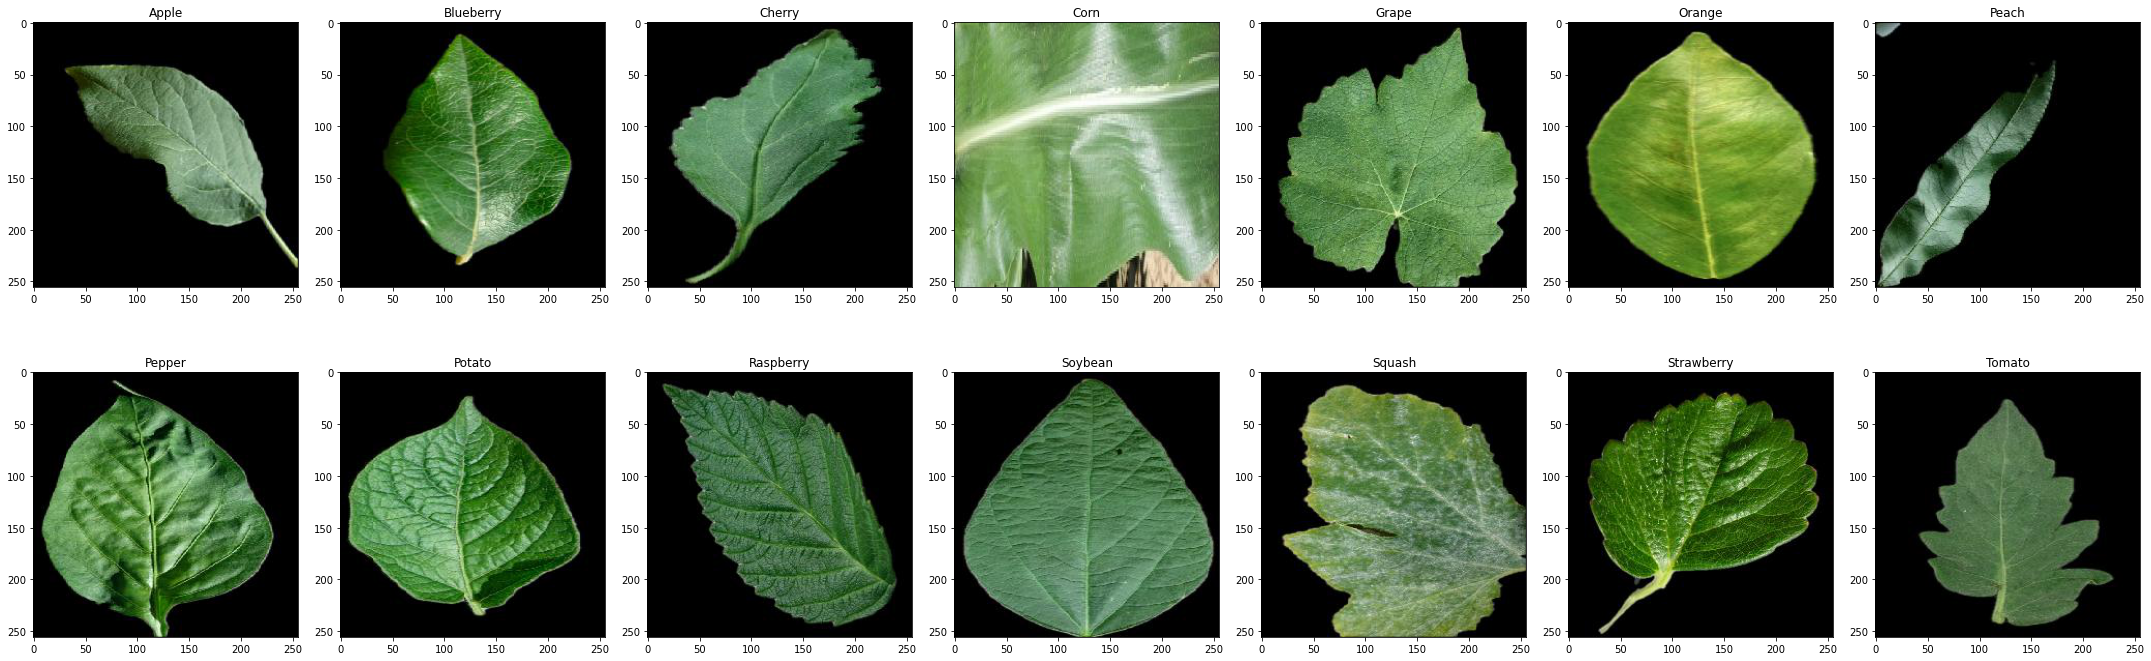

In [29]:
# Plot example images from dataset
num_row = 2
num_col = 7
fig, axes = plt.subplots(num_row, num_col, figsize=(30,10))
for i in range(len(class_names)):
  class_imgs = next(os.walk('{}/{}/'.format(dataset_folder, class_names[i])))[2]
  class_img = class_imgs[0]
  img = Image.open('{}/{}/{}'.format(dataset_folder, class_names[i], class_img))
  ax = axes[i//num_col, i%num_col]
  ax.imshow(np.array(img))
  ax.set_title('{}'.format(class_names[i]))
plt.tight_layout()
plt.show()

## creating a dataset from filenames and their corresponding classes

In [6]:
file_names = []
corresponding_classes = []

for folder in folders:
    _,_,files= next(os.walk('{}\\{}'.format(parent_dir,folder)))
    for file in files:
        file_names.append('{}\\{}\\{}'.format(parent_dir,folder,file))
        corresponding_classes.append(folder)

## Train/validation splitting

In [7]:
test_size = 0.1
image_train,image_val,class_train,class_val = train_test_split(file_names,corresponding_classes,test_size=test_size,random_state=seed,stratify=corresponding_classes)

## Creating the stratified dataset

In [8]:
import shutil
str_dataset_folder = os.getcwd() + '\\stratified_dataset'
str_train_folder = '{}\\train'.format(str_dataset_folder)
str_val_folder = '{}\\validation'.format(str_dataset_folder)

if os.path.exists(str_dataset_folder):
    shutil.rmtree(str_dataset_folder, ignore_errors=True)
    
os.mkdir(str_dataset_folder)
os.mkdir(str_train_folder)
os.mkdir(str_val_folder)
for class_name in class_names:
    os.mkdir(str_train_folder+'\\'+class_name)
    os.mkdir(str_val_folder+'\\'+class_name)
    
print('copying from original dataset to the new dataset...')

for file in image_train:
    src = file
    dst =  '{}\\{}\\{}'.format(str_train_folder,file.split('\\')[-2],file.split('\\')[-1])
    if os.path.exists(src):
        shutil.copyfile(src,dst)
print('training set has been created')

for file in image_val:
    src = file
    dst = '{}\\{}\\{}'.format(str_val_folder,file.split('\\')[-2],file.split('\\')[-1])
    if os.path.exists(src):
        shutil.copyfile(src,dst)    
print('validation set has been created')

copying from original dataset to the new dataset...
training set has been created
validation set has been created


In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train = ImageDataGenerator( rescale=1/255.,
                            rotation_range=45,
                            height_shift_range=50,
                            width_shift_range=50,
                            zoom_range=0.3,
                            horizontal_flip=True, 
                            fill_mode='reflect')

train = train.flow_from_directory(  str_train_folder,
                                    target_size=(256,256),
                                    color_mode='rgb',
                                    class_mode='categorical',
                                    batch_size=16,
                                    shuffle=True,
                                    seed=seed)

val = ImageDataGenerator( rescale=1/255.)

val = val.flow_from_directory(                      str_val_folder,
                                                    target_size=(256,256),
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    batch_size=16,
                                                    shuffle=True,
                                                    seed=seed)



Found 15955 images belonging to 14 classes.
Found 1773 images belonging to 14 classes.


In [36]:
def build_model(input_shape):
    vgg = tf.keras.applications.VGG19(  include_top=False,
                                        weights="imagenet",
                                        input_shape=input_shape
                                        )
    for layer in vgg.layers[:-2]:
        layer.trainable = False

    model = tfk.Sequential()
    model.add(vgg)
    model.add(tfkl.Conv2D(128, (3, 3), padding="same"))
    model.add(tfkl.Activation("relu"))
    model.add(tfkl.BatchNormalization(axis=-1))
    model.add(tfkl.MaxPooling2D(pool_size=(2, 2)))
    model.add(tfkl.Dropout(0.2, seed=seed))
    model.add(tfkl.Flatten())
    model.add(tfkl.Dense(units=256,kernel_initializer = tfk.initializers.GlorotUniform(seed)))
    model.add(tfkl.Activation("relu"))
    model.add(tfkl.BatchNormalization())
    model.add(tfkl.Dropout(0.2, seed=seed))
    model.add(tfkl.Dense(units=14, activation="softmax",kernel_initializer = tfk.initializers.GlorotUniform(seed)))

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

## Utility function to create folders and callbacks for training

In [37]:
from datetime import datetime


def create_folders_and_callbacks(model_name):

    exps_dir = os.path.join('experiments')
    if not os.path.exists(exps_dir):
        os.makedirs(exps_dir)

    now = datetime.now().strftime('%b%d_%H-%M-%S')

    exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
    if not os.path.exists(exp_dir):
        os.makedirs(exp_dir)

    callbacks = []

    # Model checkpoint
    ckpt_dir = os.path.join(exp_dir, 'ckpts')
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                       save_weights_only=False,
                                                       save_best_only=False) 
    callbacks.append(ckpt_callback)

    # Visualize Learning on Tensorboard
    tb_dir = os.path.join(exp_dir, 'tb_logs')
    if not os.path.exists(tb_dir):
        os.makedirs(tb_dir)

    # By default shows losses and metrics for both training and validation
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                                 profile_batch=0,
                                                 histogram_freq=1)
    callbacks.append(tb_callback)

    return exp_dir,callbacks

## Build model

In [52]:
model_name = 'AMIN_VGG_FIXED_NORM_BN_RND_Nnjj'
exp_dir,aug_callbacks = create_folders_and_callbacks(model_name=model_name)
input_shape = (256, 256, 3)

# Build model
model = build_model(input_shape)
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 8, 8, 512)         20024384  
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 128)         589952    
_________________________________________________________________
activation_16 (Activation)   (None, 8, 8, 128)         0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 2048)             

## Train the model

In [53]:
epochs = 20




history = model.fit(
    x =train,
    epochs = epochs,
    validation_data = val,
    callbacks = aug_callbacks,
).history

Epoch 1/20
998/998 [==============================] - 186s 186ms/step - loss: 0.6436 - accuracy: 0.7992 - val_loss: 0.4473 - val_accuracy: 0.8601
Epoch 2/20
998/998 [==============================] - 179s 180ms/step - loss: 0.3150 - accuracy: 0.9005 - val_loss: 0.1209 - val_accuracy: 0.9616
Epoch 3/20
998/998 [==============================] - 179s 179ms/step - loss: 0.2639 - accuracy: 0.9158 - val_loss: 0.1692 - val_accuracy: 0.9430
Epoch 4/20
998/998 [==============================] - 179s 179ms/step - loss: 0.2079 - accuracy: 0.9354 - val_loss: 0.1323 - val_accuracy: 0.9605
Epoch 5/20
998/998 [==============================] - 179s 179ms/step - loss: 0.2000 - accuracy: 0.9358 - val_loss: 0.2030 - val_accuracy: 0.9470
Epoch 6/20
998/998 [==============================] - 178s 178ms/step - loss: 0.1723 - accuracy: 0.9444 - val_loss: 0.1043 - val_accuracy: 0.9690
Epoch 7/20
998/998 [==============================] - 178s 178ms/step - loss: 0.1627 - accuracy: 0.9475 - val_loss: 0.2011 -

## Training results

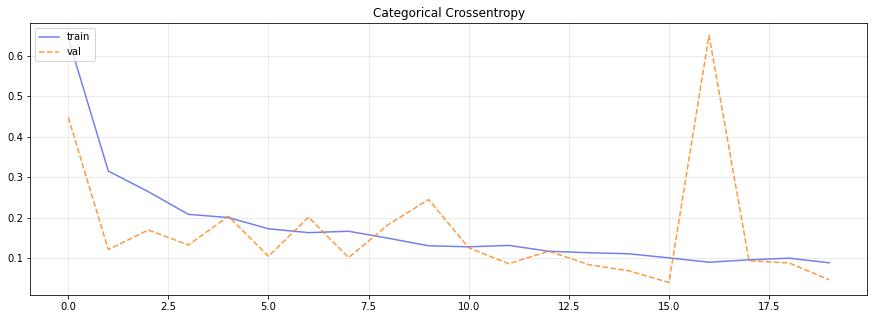

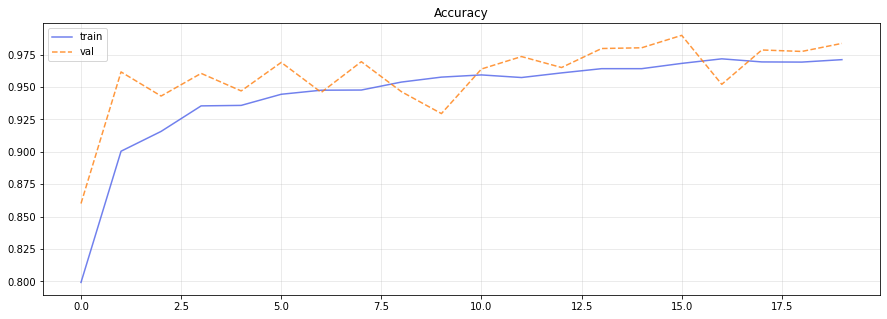

In [54]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'],label='train', alpha=.8, color='#4d61e9')
plt.plot(history['val_loss'], label='val', alpha=.8, color='#ff7f0e', linestyle='--')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='train', alpha=.8, color='#4d61e9')
plt.plot(history['val_accuracy'], label='val', alpha=.8, color='#ff7f0e', linestyle='--')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

## Saving the model

In [55]:
# Save best epoch model
# Evaluate on test
model.save("data_augmentation_experiments/AMIN_VGG_FIXED_NORM_BN_RNDddd")
model_aug = tfk.models.load_model("data_augmentation_experiments/AMIN_VGG_FIXED_NORM_BN_RNDddd")
model_aug_test_metrics = model_aug.evaluate(val, return_dict=True)


print("Test metrics with data augmentation")
print(model_aug_test_metrics)

INFO:tensorflow:Assets written to: data_augmentation_experiments/AMIN_VGG_FIXED_NORM_BN_RNDddd\assets
111/111 [==============================] - 10s 92ms/step - loss: 0.0463 - accuracy: 0.9836
Test metrics with data augmentation
{'loss': 0.04630492255091667, 'accuracy': 0.9836435317993164}
